In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from torch import optim
import os

get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

# import matplotlib.pyplot as plt
# import os
from torch.autograd import Variable
import PIL

from PIL import Image
from collections import OrderedDict
from torch.optim import lr_scheduler
 
# import torch
import numpy as np
# from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from torch.autograd import Variable
import torchvision
from collections import OrderedDict
from PIL import Image
import time,random, os


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


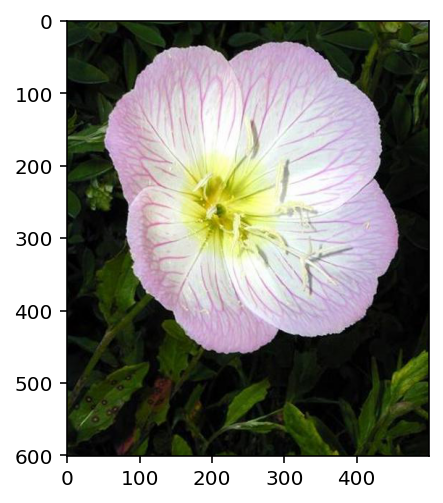

In [ ]:
os.listdir('/content/drive/MyDrive/Flower3/')

image = '/content/drive/MyDrive/Flower3/test/1/image_06743.jpg'
img = plt.imread(image)
plt.imshow(img, cmap='gray')

In [ ]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [ ]:
training_dataset = ImageFolder('/content/drive/My Drive/flowers/train', transform=train_transform)
validation_dataset = ImageFolder('/content/drive/My Drive/flowers/valid', transform=train_transform)
testing_dataset = ImageFolder('/content/drive/My Drive/flowers/test', transform=test_transform )

In [ ]:
len_train= len(training_dataset.samples)
len_test= len(testing_dataset.samples)
len_val= len(validation_dataset.samples)

In [ ]:
print(len_train)
print(len_test)
print(len_val)

6583
822
823


In [ ]:
train_loader = DataLoader(dataset=training_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, shuffle= True)
test_loader = DataLoader(dataset= testing_dataset, shuffle=False)

In [ ]:
# model = inception_v3(pretrained=True, aux_logits=False)
model=models.densenet121(pretrained=True)


In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
for pram in model.parameters():
    pram.requires_grad = False

In [ ]:
for pram in model.classifier.parameters():
    pram.requires_grad = True

In [ ]:
last_layer_input = model.classifier.in_features


In [ ]:
replaced_last_layer = nn.Linear(in_features=last_layer_input, out_features=102, bias=True)
model.classifier = replaced_last_layer


In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.001, weight_decay=0.01)


In [ ]:
number_of_epoch = 60

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []


In [ ]:
for epoch in range(number_of_epoch):
    
    train_correct = 0
    test_correct = 0
    train_iter_loss = 0.0
    test_iter_loss = 0.0
    train_iteration = 0
    test_iteration = 0
    
    model.train()
    for data,label in train_loader:
        
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        
        pred = model(data)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        
        train_iter_loss += loss.item()
        train_iteration += 1
        
        _, predicted = torch.max(pred, 1)
        train_correct += (predicted == label).sum()
        
    train_loss.append(train_iter_loss/train_iteration)
    train_accuracy.append(100*float(train_correct)/len_train)
    
    model.eval()
    with torch.no_grad():
        for data,label in val_loader:
        
            data = data.to(device)
            label = label.to(device)
        
            pred = model(data)
            loss = loss_fn(pred, label)
        
            test_iter_loss += loss.item()
            test_iteration += 1
        
            _, predicted = torch.max(pred, 1)
            test_correct += (predicted == label).sum()
        
    test_loss.append(test_iter_loss/test_iteration)
    test_accuracy.append(100*float(test_correct)/len_val)
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}'
           .format(epoch+1, number_of_epoch, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label=' Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss')
# plt.legend(loc='best')
plt.legend(['train','validation'])
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.title("Train-Validation Acc")
plt.plot( train_accuracy, label=' Training Accuracy')
plt.plot(test_accuracy, label='Validation Acc')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('acc')
# plt.legend(loc='best')
plt.legend(['train','validation'])
plt.show()

In [ ]:
corrected = 0


In [ ]:
model.eval()
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)
    
    pred = model(data)
    _, predicted = torch.max(pred, 1)
    
    corrected += (predicted == label).sum()

    y_true=label
    y_pred=predicted
    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7   
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2* (precision*recall) / (precision + recall + epsilon)

In [ ]:
accuracy = 100 * float(corrected)/ len_test

print(f'Test accuracy is {accuracy :.3f}')

In [ ]:
checkpoint = {'class_to_idx': training_dataset.class_to_idx,
              'optimizer_dict': optimizer.state_dict(),
              'state_dict': model.state_dict()}

In [ ]:
torch.save(checkpoint, '/content/drive/MyDrive/checkpoint.pth')


In [ ]:
def load_checkpoint(filepath):
    pretrained_model = model
    if torch.cuda.is_available():
        loaded_model = torch.load(filepath)
    else:
        loaded_model = torch.load(filepath, map_location=lambda storage, loc: storage)
    pretrained_model.class_idx = loaded_model['class_to_idx']
    # pretrained_model.classifier = loaded_model['classifier']
    pretrained_model.load_state_dict(loaded_model['state_dict'])
    
    for param in pretrained_model.parameters():
        param.requires_grad = False
    
    if torch.cuda.is_available():
        pretrained_model.cuda()
    
    return pretrained_model

In [ ]:
model = load_checkpoint('/content/drive/MyDrive/checkpoint.pth')


In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Resize the image and make the shorter side 256 pixels
    width, height = image.size
    ratio = width / height
    if width < height:
        width = 256
        height = width / ratio
    elif width > height:
        height = 256
        width = ratio * height
    else:
        width, height = 256
    image = image.resize((round(width), round(height)))
    
    # Crop the image and convert it to an nparray
    np_image = np.array(image.crop((16, 16, 240, 240)))
    
    # Normalize the image
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    np_image = (np_image / 255 - means) / stds
    
    # Change the color channel to meet PyTorch expectations
    return np_image.transpose(2, 0, 1)

"""To check your work, the function below converts a PyTorch tensor and displays it in the notebook. 
If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions)."""

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension,
    # but matplotlib assumes it is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    # Implement the code to predict the class from an image file
    image = Image.open(image_path)
    image_tensor = torch.from_numpy(process_image(image))
    image_tensor.unsqueeze_(0)
    model = model.double()
    
    # Swap the dictionary keys and values to obtain the numerical classes of the flower names
    idx_to_class = {v: k for k, v in model.class_idx.items()}
    
    model.to(device)
    output = model.forward(image_tensor.to(device))
    largest = torch.exp(output).data.topk(topk)
    probs, classes = largest[0].tolist()[0], list(map(lambda i:idx_to_class[i], 
                                                      largest[1].tolist()[0]))
    
    return probs, classes

In [ ]:
img = random.choice(os.listdir('/content/drive/My Drive/flowers/test/1/'))
image_path = '/content/drive/My Drive/flowers/test/1/' + img

probs, classes = predict(image_path, model)
print(probs)
print(classes)

[449.47945613740984, 160.95416451535124, 50.657320419426185, 39.58996716110979, 33.09142310522723]
['1', '97', '19', '44', '51']


In [ ]:
def predict_names(image_path, model, cat_to_name, topk=5):
    probs, classes = predict(image_path, model, topk)
    names = []
    for c in classes:
        names.append(cat_to_name[c])
    return probs, names

In [ ]:
with open('/content/drive/My Drive/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [ ]:
probs, names = predict_names(image_path, model, cat_to_name)

print(probs)
print(names)

[449.47945613740984, 160.95416451535124, 50.657320419426185, 39.58996716110979, 33.09142310522723]
['pink primrose', 'mallow', 'balloon flower', 'poinsettia', 'petunia']


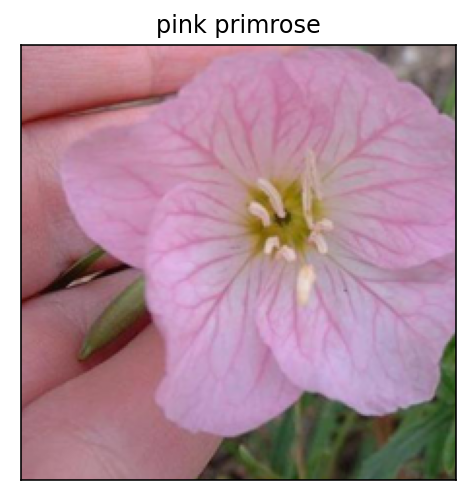

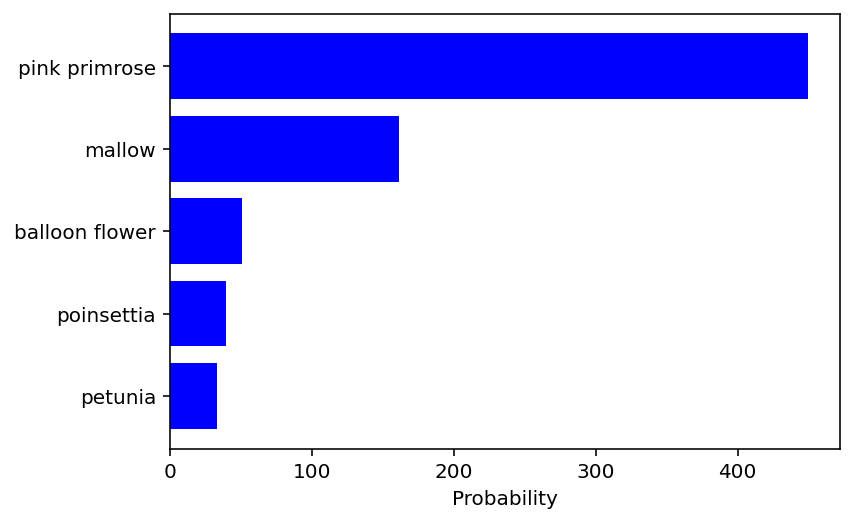

In [ ]:
test_flower = image_path
probs, names = predict_names(test_flower, model, cat_to_name)
sanity_check = process_image(Image.open(test_flower))

# Display the test flower image
flower_ax = imshow(sanity_check)
flower_ax.set_yticks(list())
flower_ax.set_xticks(list())
flower_ax.set_title(names[0])
    
# Plot the predictions and related probabilities
fig, ax = plt.subplots()
y_pos = np.arange(len(names))
ax.barh(y_pos, probs, align='center', color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel('Probability')
plt.show()